In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

from glob import glob

def cell_attributes():
    import yaml

    with open("../configs/prw/grid_id0/cell0.yaml") as f:
        configs = yaml.safe_load(f)
    D = configs["D"]
    alpha = configs["alpha"]
    return D, alpha


def plot_distributions(cms):
    from substrate.substrates import Substrate

    sub_generator = Substrate(N_mesh=200, L_box=50)
    chi = sub_generator.two_state_sub()

    fig = plt.figure(figsize=(5, 5))

    ax = plt.subplot2grid((3, 3), (1, 0), rowspan=2)
    ax.hist(cms.y.values, color="blue", orientation="horizontal")
    ax.set_ylim([0, 50])
    ax.set_xlabel("PDF(y)")
    ax.set_ylabel("y")

    ax = plt.subplot2grid((3, 3), (0, 1), colspan=2)
    ax.hist(cms.x.values, color="red")
    ax.set_xlim([0, 50])
    ax.set_xlabel("x")
    ax.set_ylabel("PDF(x)")

    ax = plt.subplot2grid((3, 3), (1, 1), colspan=2, rowspan=2)
    ax.scatter(cms.x, cms.y, c=range(cms.shape[0]), cmap="viridis")
    ax.contour(
        chi, levels=[0.5], colors=["black"], linewidths=[3], extent=[0, 50, 0, 50]
    )
    import matplotlib as mplt

    times = cms["time[hr]"].values
    norm = mplt.colors.Normalize(vmin=times[0], vmax=times[-1] / 24)
    cbar = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap="viridis"), location="bottom", pad=-0.2
    )
    cbar.set_label("Days")
    ax.axis("off")


def hist_hopping_time(cms):
    # cms["bin"] = [0 if np.fabs(x-12.5)<2.5 else 1 for x in cms.x.values]

    # index one after which the cell has hopped
    hopped_indx = np.where(np.diff(cms.bin.values) != 0)[0]
    cum_time_before_hop = np.diff(cms.iloc[hopped_indx]["time[hr]"].values, prepend=0)
    return cum_time_before_hop


def read_all_files(pathname_fmt, n_workers):
    files = glob(pathname_fmt)
    with Pool(processes=n_workers) as p:
        res = p.map_async(_read_file, files)
        p.close()
        p.join()

    res = res.get(timeout=1)
    return pd.concat(res).reset_index(drop=True)


def _read_file(file):
    df = pd.read_csv(file).drop(columns=["Unnamed: 0"])
    df["time[hr]"] = df.index * 2000 * 0.002 * 8 / 60
    return df


def _calc_v(df):
    x_dis = np.diff(df.x) * 6  # mu
    delta_t = 2000 * 0.002 * 8 / 60  # hr
    return x_dis / delta_t


def _calc_a(df):
    x = df.x.values[1:-1]
    x_after = df.x.values[2:]
    x_before = df.x.values[:-2]
    delta_t = 2000 * 0.002 * 8 / 60  # hr
    return (x_after - 2 * x + x_before) * 6 / delta_t**2  # mu/hr^2


def compute_v_a(cms):
    v = _calc_v(cms)
    a = _calc_a(cms)
    df = cms.iloc[1:-1].copy()
    df["v[mu/hr]"] = v[1:]
    df["a[mu/hr2]"] = a
    return df


In [2]:
res = read_all_files("../output/prw/grid_id*/run_*/result.csv", n_workers=48)
N = 48 * 11 * 5000000 / 2000
D, alpha = cell_attributes()
print(f"Should have {N} data points.")
print(f"Cells parameters are: D = {D}, alpha = {alpha}")
res

Should have 1320000.0 data points.
Cells parameters are: D = 0.002, alpha = 0.5


,x,y,time[hr]
0,12.500000,25.000000,0.000000
1,13.839693,25.953915,0.533333
2,14.701623,26.121888,1.066667
3,15.321628,26.018838,1.600000
4,15.681362,25.977124,2.133333
...,...,...,...
1319995,10.877487,25.718940,1330.666667
1319996,10.887650,25.732415,1331.200000
1319997,10.950553,25.843967,1331.733333
1319998,11.019720,25.948069,1332.266667


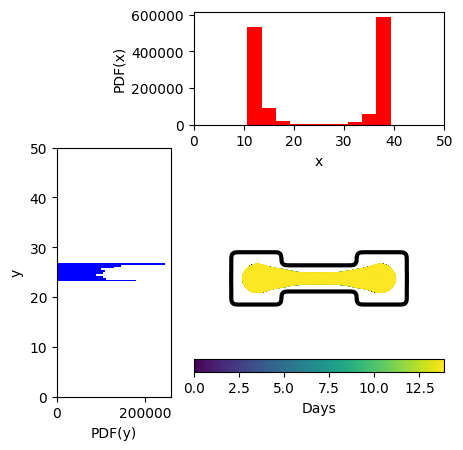

In [6]:
plot_distributions(res)

In [12]:
cms_v_a = compute_v_a(res)
cms_v_a

,x,y,time[hr],v[mu/hr],a[mu/hr2]
1,13.839693,25.953915,0.533333,9.696713,-10.077807
2,14.701623,26.121888,1.066667,6.975055,-5.103109
3,15.321628,26.018838,1.600000,4.047014,-5.490077
4,15.681362,25.977124,2.133333,3.547695,-0.936224
5,15.996713,25.890838,2.666667,2.951360,-1.118127
...,...,...,...,...,...
1319994,10.831575,25.623455,1330.133333,0.516505,0.518630
1319995,10.877487,25.718940,1330.666667,0.114341,-0.754057
1319996,10.887650,25.732415,1331.200000,0.707651,1.112456
1319997,10.950553,25.843967,1331.733333,0.778131,0.132150


In [19]:
cms_v_a = cms_v_a[cms_v_a["v[mu/hr]"] > -45]
cms_v_a = cms_v_a[cms_v_a["a[mu/hr2]"] < 80]


nbins = 50
v_min = cms_v_a["v[mu/hr]"].min()
v_max = cms_v_a["v[mu/hr]"].max()
x_min = 0
x_max = 50

dx = (x_max - x_min) / (nbins - 1)
dv = (v_max - v_min) / (nbins - 1)

cms_v_a["xbin"] = np.floor((cms_v_a.x.values - x_min) / dx)
cms_v_a["vbin"] = np.floor((cms_v_a["v[mu/hr]"].values - v_min) / dv)

cms_v_a = cms_v_a.astype({'xbin': 'int'})
cms_v_a = cms_v_a.astype({'vbin': 'int'})

cms_v_a.head(5)

,x,y,time[hr],v[mu/hr],a[mu/hr2],xbin,vbin
1,13.839693,25.953915,0.533333,9.696713,-10.077807,13,31
2,14.701623,26.121888,1.066667,6.975055,-5.103109,14,29
3,15.321628,26.018838,1.600000,4.047014,-5.490077,15,27
4,15.681362,25.977124,2.133333,3.547695,-0.936224,15,26
5,15.996713,25.890838,2.666667,2.951360,-1.118127,15,26


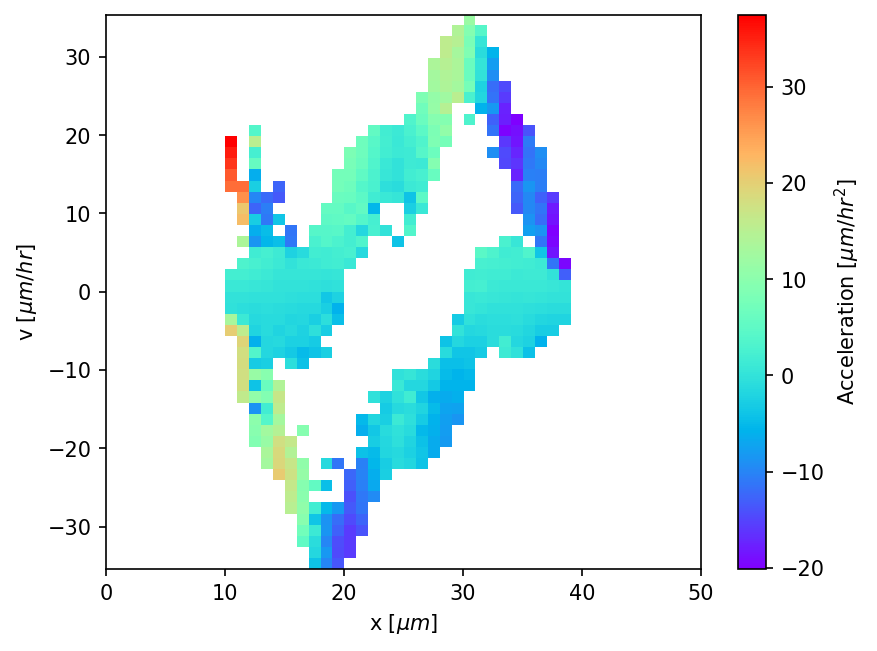

In [20]:
acc_map = np.zeros(shape=(nbins, nbins)) * np.nan

for (xbin, vbin), df in cms_v_a.groupby(["xbin", "vbin"]):
    acc_map[vbin, xbin] = df["a[mu/hr2]"].mean()

plt.imshow(acc_map, extent=[x_min, x_max, v_min, v_max], origin="lower", cmap='rainbow')
# plt.xticks([0, 10, 20, 30, 40, 50], [0, 10, 20, 30, 40, 50])
# plt.ylim(-800, -600)
plt.axis("auto")
plt.xlabel("x $[\mu m]$")
plt.ylabel("v $[\mu m/hr]$")
cbar = plt.colorbar()
cbar.set_label(r"Acceleration $[\mu m/hr^2]$")
plt.gcf().dpi = 150